In [123]:
# Default imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Pre processing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

# Model evaluation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MeanShift, OPTICS, Birch, AffinityPropagation
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier

import warnings
warnings.filterwarnings('ignore')

In [124]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Methodology

Now that we have preprocessed our dataset and extracted interesting features,  we are going to test several algorithms. We will proceed from the algorithm which we expect to have the worse results - for the sake of testing - to the algorithm which we expect to be the most effective.

# Preparation (preprocessing + utility functions)

In [125]:
path = 'data/'
data = pd.read_csv(path + "processed_data.csv",header=0,index_col='ID')
print(data.shape)
data.head(10)

(249, 138)


,bug_type,species,nb_pixels_ratio,image_symmetry_index,mask_bb_symmetry_index,orthogal_lines_ratio,roundness,mean_centroid_distance,std_centroid_distance,max_centroid_distance,...,fourier_descriptor_real_5,fourier_descriptor_imag_5,fourier_descriptor_real_6,fourier_descriptor_imag_6,fourier_descriptor_real_7,fourier_descriptor_imag_7,fourier_descriptor_real_8,fourier_descriptor_imag_8,fourier_descriptor_real_9,fourier_descriptor_imag_9
ID,,,,,,,,,,,,,,,,,,,,,
1,Bee,Apis mellifera,0.007199,65.842518,70.059270,0,0.046706,245.172338,55.348483,362.548639,...,-0.001702,0.008064,-0.001693,0.002286,-0.003509,0.004708,-0.000954,0.001356,-0.002313,0.000987
2,Bee,Apis mellifera,0.008306,68.896841,40.143673,0,0.048440,279.998031,85.163883,478.802953,...,-0.003566,-0.005841,-0.003950,0.001051,0.000611,-0.007472,-0.002777,-0.003921,0.002142,-0.001168
3,Bee,Apis mellifera,0.021768,69.742772,45.869792,0,0.046958,432.496928,109.688767,676.046287,...,-0.017603,-0.006018,-0.004180,0.005942,-0.007836,0.002944,-0.008795,0.002132,-0.009261,-0.002615
4,Bee,Apis mellifera,0.012867,54.315953,35.557123,0,0.043529,328.675429,95.409134,557.031816,...,-0.008513,0.005554,-0.005088,-0.001124,-0.004936,-0.001308,-0.000717,-0.003153,-0.006001,0.002577
5,Bee,Apis mellifera,0.008957,75.907980,62.907427,0,0.037005,267.675617,94.401531,505.953034,...,-0.005335,-0.003086,-0.011826,-0.000144,-0.005107,-0.004499,-0.002891,-0.001483,-0.000449,-0.002934
6,Bee,Apis mellifera,0.005773,63.085727,43.130128,0,0.044037,211.581232,70.099682,376.800370,...,-0.007637,-0.002963,-0.002410,0.002479,-0.005576,-0.002805,-0.002841,-0.001585,-0.002785,0.002163
7,Bee,Apis mellifera,0.005499,49.956948,56.415653,0,0.074186,230.782950,72.090803,376.501782,...,-0.005661,-0.000434,-0.005076,0.000524,-0.003880,-0.000092,-0.003102,0.000175,-0.002973,0.000110
8,Bee,Apis mellifera,0.007270,63.134435,49.307215,0,0.064155,273.800951,94.931425,447.646287,...,-0.011309,-0.001321,-0.005797,0.010358,-0.004560,0.002892,-0.006528,-0.000745,-0.006112,0.005487
9,Bee,Apis mellifera,0.007018,17.359507,51.374885,0,0.057295,219.473831,87.781720,390.454913,...,-0.003719,-0.003716,-0.003961,-0.005846,-0.007110,-0.001028,-0.004216,-0.001653,-0.003166,-0.000645


In [50]:
def evaluate_predictions(model,y,y_pred):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    classes = model.classes_ if hasattr(model, 'classes_') else np.unique(y)
    print(classification_report(y, y_pred, target_names=classes))

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

In [96]:
def majority_vote(clusters, labels):
    y_pred = np.zeros_like(clusters)
    unique_clusters = np.unique(clusters)
    #print(np.unique(unique_clusters), np.unique(labels))
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_labels = labels[cluster_indices]
        majority_label = np.argmax(np.bincount(cluster_labels))
        y_pred[cluster_indices] = majority_label
    return y_pred

from sklearn.preprocessing import LabelEncoder
def evaluate_clustering(model,X,labels, plot=False):
    # Fit the model and predict cluster labels
    model.fit(X)
    cluster_labels = model.labels_

    # Evaluate clustering performance
    silhouette_index = silhouette_score(X, cluster_labels,metric='euclidean')
    print("Silhouette score : ", silhouette_index)

    # Perform majority voting using encoded labels then decode
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    y_pred_encoded = majority_vote(cluster_labels, encoded_labels)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Evaluate predictions as if it were a classification task
    evaluate_predictions(model, labels, y_pred)

    if plot:
        # Create a scatter plot of the projected data with color-coded clusters
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=cluster_labels,style=labels, palette='viridis')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('{0} clustering results '.format(model.__name__))
        plt.show()

In [60]:
def evaluate_classifier(model, X, y):
    global cv
    # Perform cross-validated prediction
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)

    evaluate_predictions(model,y, y_pred_cv)

In [56]:
from hyperopt import hp, fmin, tpe, space_eval
def search_parameters(obj_func, search_space, max_evals=100):
    best = fmin(obj_func, search_space, algo=tpe.suggest, max_evals=max_evals)
    space_evaluation = space_eval(search_space, best)
    print("Best hyperparameters:", space_evaluation)
    return space_evaluation

In [12]:
X = data.drop(columns=['bug_type','species'])
y = data['bug_type']
classes = np.unique(y)
n_classes = len(classes)

**Normalisation: TO DO**

In [13]:
scaled_X = StandardScaler().fit_transform(X)

In [35]:
# K Fold for training
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=10)

**Exemple d'utilisation des fonctions pour un algorithme**

In [22]:
def objective(params):
    rf = RandomForestClassifier(**params, random_state=10)
    # Calculate score over the predefined folds
    scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    # Return the negative mean accuracy because the function is minimized
    return -scores.mean()  

search_space = {
    'n_estimators': hp.choice('n_estimators', [10,50, 100, 150, 200, 250]),
    'max_depth': hp.choice('max_depth', range(1, 21)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
}

best_params = search_parameters(objective, search_space, max_evals=100)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



  2%|▏         | 2/100 [00:01<00:55,  1.76trial/s, best loss: -0.7431020408163265]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



  4%|▍         | 4/100 [00:01<00:31,  3.01trial/s, best loss: -0.7431020408163265]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



  5%|▌         | 5/100 [00:01<00:33,  2.80trial/s, best loss: -0.7548571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



  6%|▌         | 6/100 [00:02<00:36,  2.56trial/s, best loss: -0.7548571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



  7%|▋         | 7/100 [00:04<01:25,  1.08trial/s, best loss: -0.7548571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



  9%|▉         | 9/100 [00:05<01:00,  1.49trial/s, best loss: -0.7548571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 12%|█▏        | 12/100 [00:06<00:36,  2.41trial/s, best loss: -0.7548571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 14%|█▍        | 14/100 [00:07<00:31,  2.75trial/s, best loss: -0.7548571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 15%|█▌        | 15/100 [00:07<00:30,  2.81trial/s, best loss: -0.754938775510204] 

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 16%|█▌        | 16/100 [00:07<00:30,  2.79trial/s, best loss: -0.754938775510204]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 18%|█▊        | 18/100 [00:08<00:24,  3.35trial/s, best loss: -0.754938775510204]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 20%|██        | 20/100 [00:10<00:57,  1.39trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 21%|██        | 21/100 [00:11<00:52,  1.51trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 22%|██▏       | 22/100 [00:13<01:27,  1.12s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 23%|██▎       | 23/100 [00:14<01:22,  1.07s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 24%|██▍       | 24/100 [00:16<01:31,  1.20s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 25%|██▌       | 25/100 [00:17<01:33,  1.24s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 26%|██▌       | 26/100 [00:17<01:12,  1.02trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 27%|██▋       | 27/100 [00:19<01:19,  1.09s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 28%|██▊       | 28/100 [00:21<01:36,  1.35s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 29%|██▉       | 29/100 [00:24<02:17,  1.93s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 30%|███       | 30/100 [00:24<01:43,  1.48s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 31%|███       | 31/100 [00:26<01:47,  1.56s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 32%|███▏      | 32/100 [00:26<01:20,  1.19s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 33%|███▎      | 33/100 [00:28<01:35,  1.42s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 34%|███▍      | 34/100 [00:29<01:13,  1.12s/trial, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 35%|███▌      | 35/100 [00:29<00:58,  1.11trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 37%|███▋      | 37/100 [00:30<00:42,  1.49trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 38%|███▊      | 38/100 [00:30<00:32,  1.90trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 39%|███▉      | 39/100 [00:31<00:33,  1.84trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 40%|████      | 40/100 [00:32<00:31,  1.90trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 42%|████▏     | 42/100 [00:33<00:28,  2.03trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 45%|████▌     | 45/100 [00:33<00:19,  2.82trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 46%|████▌     | 46/100 [00:34<00:21,  2.55trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 47%|████▋     | 47/100 [00:35<00:24,  2.14trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 49%|████▉     | 49/100 [00:36<00:24,  2.09trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 50%|█████     | 50/100 [00:37<00:29,  1.72trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 51%|█████     | 51/100 [00:37<00:28,  1.71trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 52%|█████▏    | 52/100 [00:38<00:25,  1.88trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 53%|█████▎    | 53/100 [00:38<00:27,  1.72trial/s, best loss: -0.7667755102040815]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 55%|█████▌    | 55/100 [00:39<00:25,  1.76trial/s, best loss: -0.7788571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 56%|█████▌    | 56/100 [00:41<00:31,  1.39trial/s, best loss: -0.7788571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 57%|█████▋    | 57/100 [00:43<00:53,  1.25s/trial, best loss: -0.7788571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 58%|█████▊    | 58/100 [00:44<00:47,  1.14s/trial, best loss: -0.7788571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 59%|█████▉    | 59/100 [00:46<00:58,  1.42s/trial, best loss: -0.7788571428571428]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 61%|██████    | 61/100 [00:47<00:31,  1.23trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 63%|██████▎   | 63/100 [00:47<00:18,  2.01trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 64%|██████▍   | 64/100 [00:47<00:14,  2.47trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 65%|██████▌   | 65/100 [00:47<00:11,  2.98trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 66%|██████▌   | 66/100 [00:48<00:10,  3.22trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 67%|██████▋   | 67/100 [00:48<00:09,  3.52trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 68%|██████▊   | 68/100 [00:48<00:09,  3.35trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 69%|██████▉   | 69/100 [00:48<00:08,  3.71trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 70%|███████   | 70/100 [00:49<00:07,  3.79trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 71%|███████   | 71/100 [00:49<00:07,  4.07trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 72%|███████▏  | 72/100 [00:49<00:06,  4.05trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 73%|███████▎  | 73/100 [00:50<00:13,  2.06trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 75%|███████▌  | 75/100 [00:50<00:08,  3.07trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 76%|███████▌  | 76/100 [00:51<00:08,  2.80trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 77%|███████▋  | 77/100 [00:51<00:08,  2.79trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 78%|███████▊  | 78/100 [00:52<00:09,  2.21trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 79%|███████▉  | 79/100 [00:52<00:08,  2.56trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 80%|████████  | 80/100 [00:52<00:07,  2.82trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 81%|████████  | 81/100 [00:53<00:08,  2.17trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 84%|████████▍ | 84/100 [00:54<00:05,  3.03trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 86%|████████▌ | 86/100 [00:55<00:05,  2.40trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 87%|████████▋ | 87/100 [00:55<00:04,  2.82trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 89%|████████▉ | 89/100 [00:56<00:04,  2.50trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 90%|█████████ | 90/100 [00:56<00:03,  2.59trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 92%|█████████▏| 92/100 [00:57<00:02,  3.31trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 94%|█████████▍| 94/100 [00:58<00:02,  2.64trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 95%|█████████▌| 95/100 [00:58<00:01,  3.02trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 97%|█████████▋| 97/100 [00:59<00:00,  3.44trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 98%|█████████▊| 98/100 [00:59<00:00,  3.37trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 99%|█████████▉| 99/100 [01:00<00:00,  2.07trial/s, best loss: -0.7789387755102041]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



100%|██████████| 100/100 [01:00<00:00,  1.65trial/s, best loss: -0.7789387755102041]
Best hyperparameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.10288181314190446, 'n_estimators': 50}


c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classific

Accuracy: 0.7791164658634538
Precision: 0.7294865737459642
Recall: 0.7791164658634538
F1 Score: 0.7447367699207906
              precision    recall  f1-score   support

         Bee       0.75      0.91      0.82       115
   Bumblebee       0.80      0.82      0.81       100
   Butterfly       1.00      0.47      0.64        15
   Dragonfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         9
        Wasp       0.00      0.00      0.00         9

    accuracy                           0.78       249
   macro avg       0.43      0.37      0.38       249
weighted avg       0.73      0.78      0.74       249



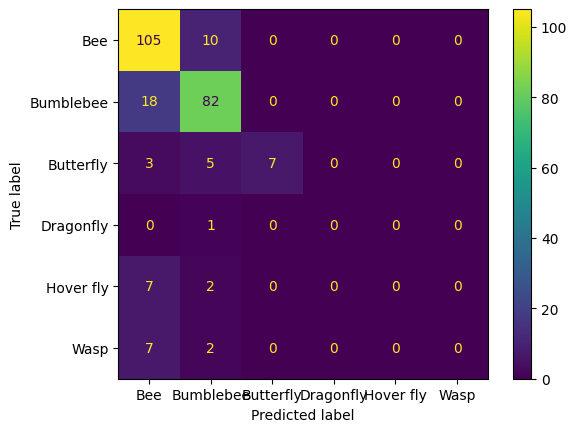

In [62]:
evaluate_classifier(RandomForestClassifier(**best_params, random_state=10), X, y)

# Feature Importance

In [64]:
rf = RandomForestClassifier(**best_params,random_state=20)
rf.fit(X, y)

RandomForestClassifier(max_depth=12, min_samples_leaf=3,
                       min_samples_split=0.10288181314190446, n_estimators=50,
                       random_state=20)

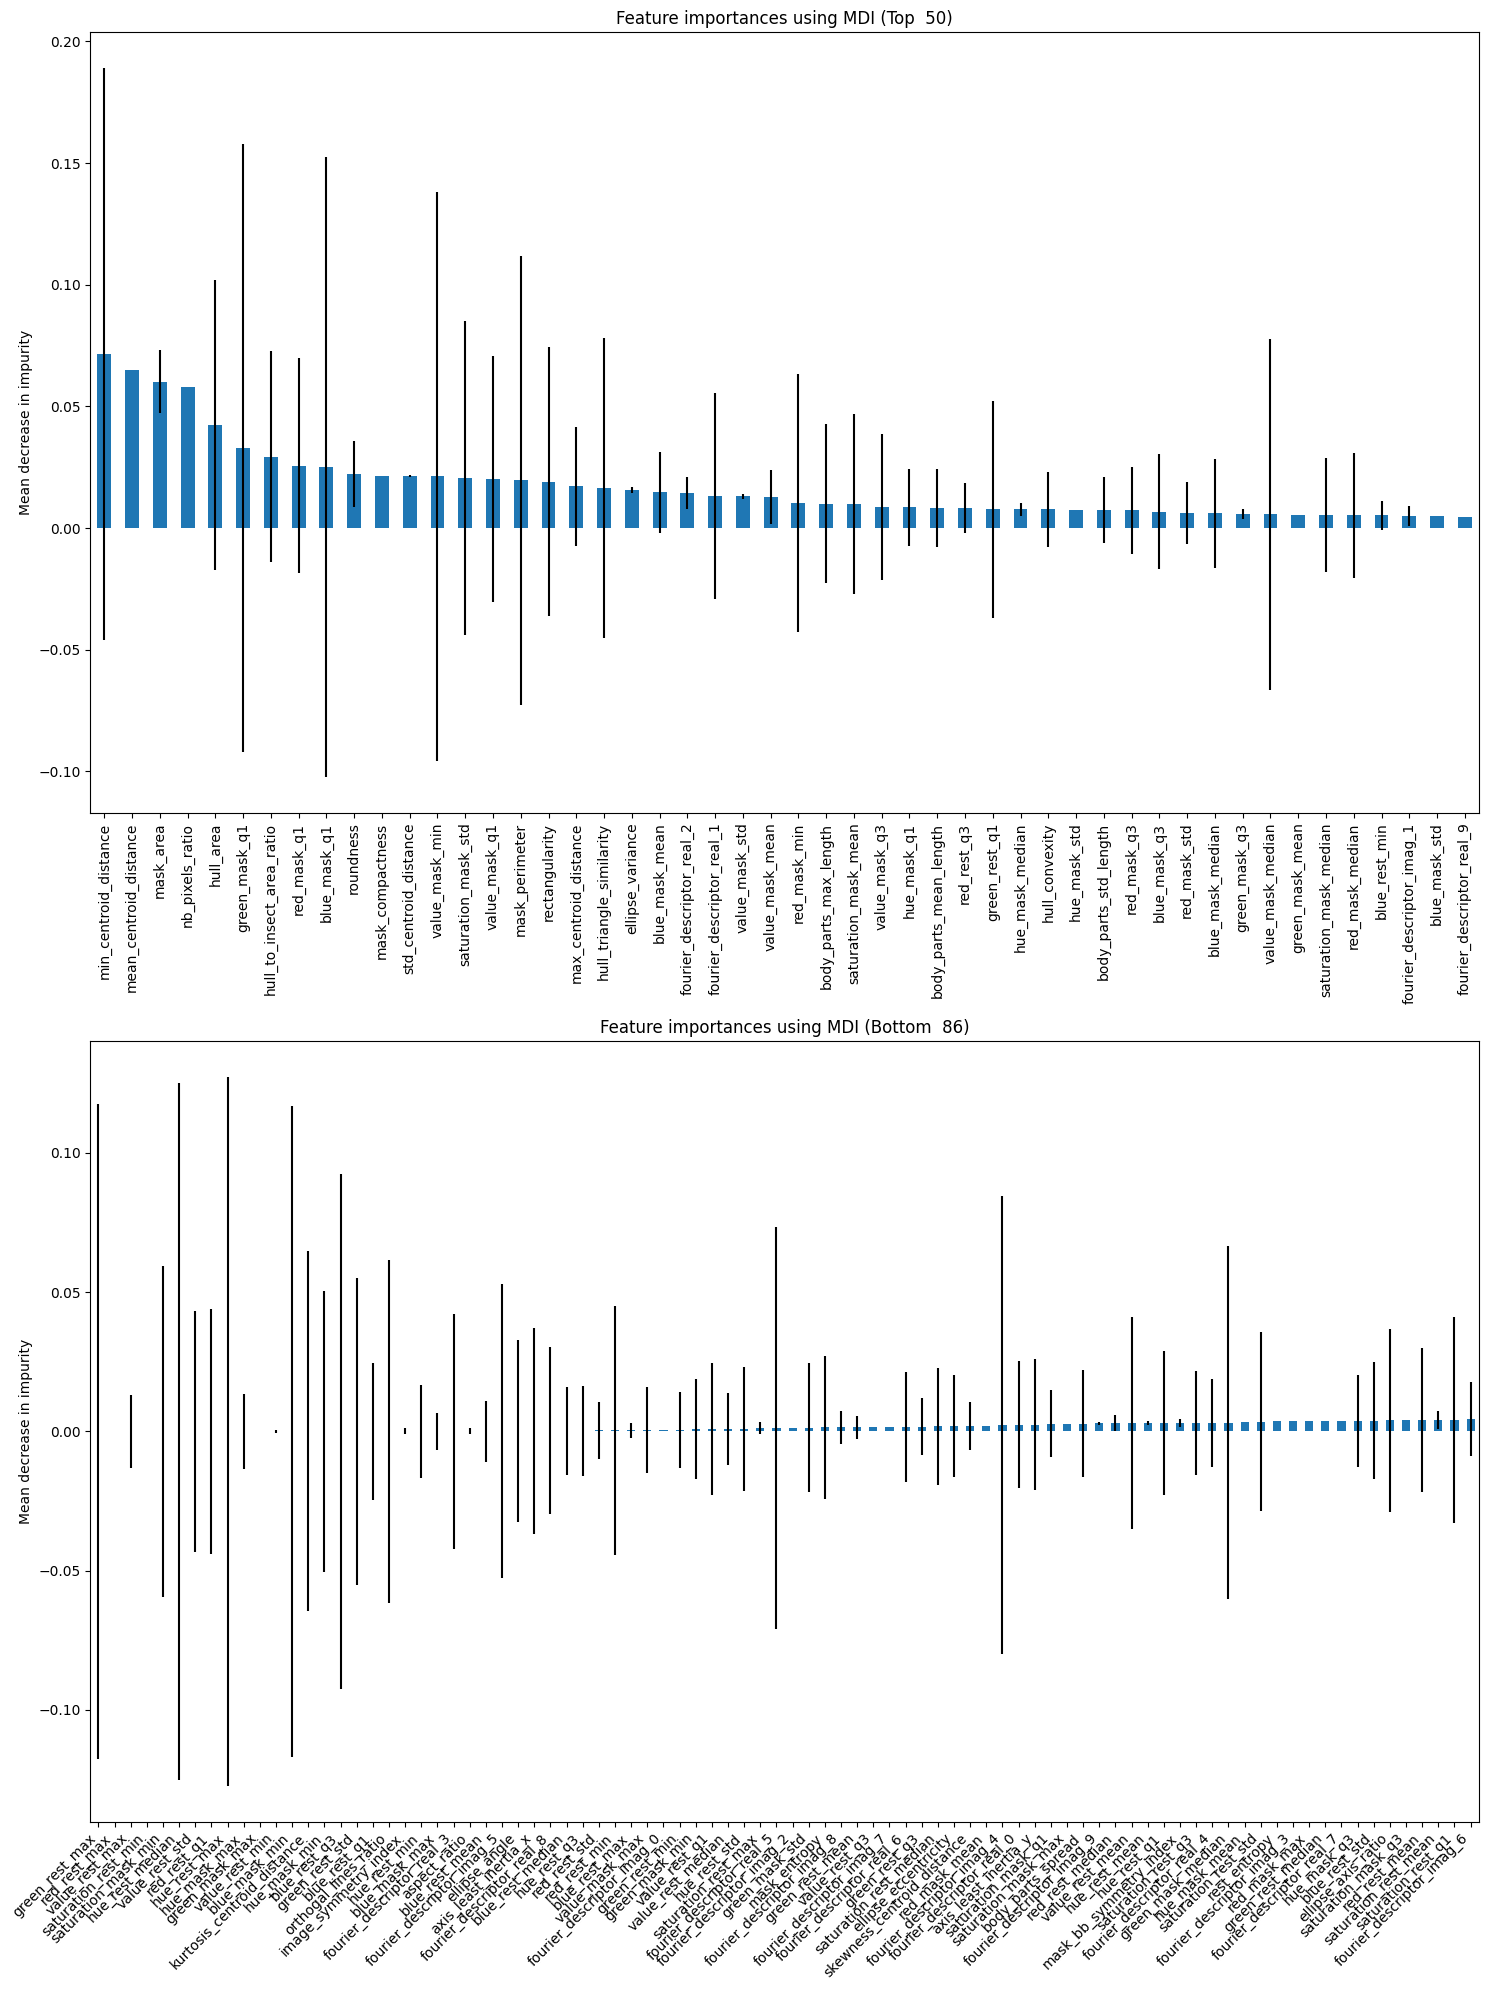

In [65]:
def make_graph(forest_importances,std,ax,n_features,asc=False):
    forest_importances2 = forest_importances.sort_values(ascending=asc)
    if n_features is not None:
        forest_importances2 = forest_importances2[:n_features]
        std2 = std[:n_features]

    forest_importances2.plot.bar(yerr=std2, ax=ax)
    way = "Bottom " if asc else "Top "
    ax.set_title("Feature importances using MDI ({0} {1})".format(way,n_features if n_features is not None else ""))
    ax.set_ylabel("Mean decrease in impurity")
    plt.xticks(rotation=45, ha='right')
    features = 
    return features

def plot_feature_importances(n_features=50):
    total_n_features = len(X.columns)
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=X.columns)
    n = 1 if n_features is None else 2
    fig, axs = plt.subplots(figsize=(15,20),nrows=n,ncols=1)
    make_graph(forest_importances,std,axs[0],n_features,asc=False)
    if n == 2:
        make_graph(forest_importances,std,axs[1],total_n_features - n_features,asc=True)
    fig.tight_layout()
    plt.show()
plot_feature_importances(n_features=50)

import shap
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

# Application of machine or deep learning algorithms

## Clustering (unsupervised learning) methods

Here, because we have the ground truth (we know the labels), it may be better to use algorithms which have the number of clusters as the main parameter. Indeed, as parameterization is an important factor in performance, if we already know the optimal value for a parameter, it is a significant advantage. We will also try other algorithms but they will probably not work as well and will require more parameterization work.

### Algorithms with n_clusters as parameter

**TO DO**

In [113]:
forest_importances = pd.Series(rf.feature_importances_, index=X.columns)
forest_importances.sort_values(ascending=False, inplace=True)
k = 30
top_k_features = forest_importances.index[:k] 
indices_of_top_k_features = [X.columns.get_loc(feature) for feature in top_k_features]
lim_X = scaled_X[:, indices_of_top_k_features]

c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\milen\AppData\Local\Programs\Python\Python311\Li

Silhouette score :  0.14183904070713774
Accuracy: 0.751004016064257
Precision: 0.6958374187536107
Recall: 0.751004016064257
F1 Score: 0.7211964016881126
              precision    recall  f1-score   support

         Bee       0.73      0.84      0.78       115
   Bumblebee       0.77      0.79      0.78       100
   Butterfly       0.85      0.73      0.79        15
   Dragonfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         9
        Wasp       0.00      0.00      0.00         9

    accuracy                           0.75       249
   macro avg       0.39      0.39      0.39       249
weighted avg       0.70      0.75      0.72       249



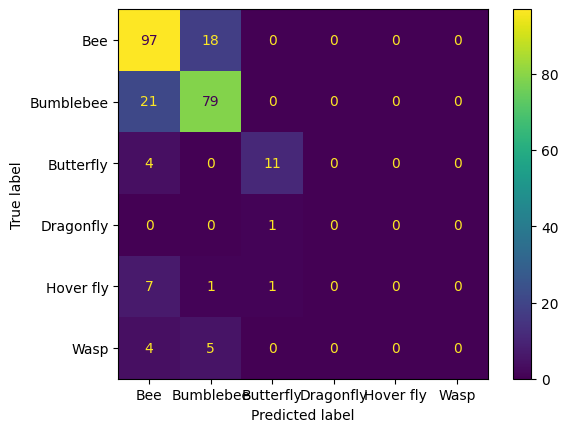

In [121]:
kmeans = KMeans(n_clusters=n_classes,random_state=10)
evaluate_clustering(kmeans, lim_X, y, plot=False)

Silhouette score :  0.11356050499116649
Accuracy: 0.7791164658634538
Precision: 0.747898121351812
Recall: 0.7791164658634538
F1 Score: 0.7479572775589448
              precision    recall  f1-score   support

         Bee       0.70      0.97      0.81       115
   Bumblebee       0.94      0.74      0.83       100
   Butterfly       0.82      0.60      0.69        15
   Dragonfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         9
        Wasp       0.00      0.00      0.00         9

    accuracy                           0.78       249
   macro avg       0.41      0.38      0.39       249
weighted avg       0.75      0.78      0.75       249



c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\milen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

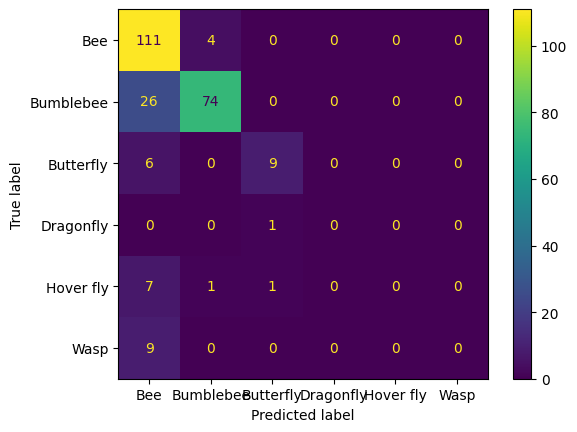

In [ ]:
hac = AgglomerativeClustering(n_clusters=n_classes, linkage='ward')
evaluate_clustering(hac, lim_X, y, plot=False)

In [ ]:
gmm = GaussianMixture(n_components=n_classes)
apply_clustering(gmm)

In [ ]:
spectral = SpectralClustering(n_clusters=n_classes,affinity ='nearest_neighbors',n_neighbors=5)
apply_clustering(spectral)

In [ ]:
#......

### Algorithms without n_clusters as parameter

We have tested the most common clustering algorithms that allow us to set the number of clusters. For the sake of testing we will try with DBSCAN, but it is harder to parametrize here and we will proably have to deal with outliers (points with no vcluster).

**TO DO**

## Classification (supervised learning) methods that are neither deep nor ensemble learning

**TO DO**

## Ensemble classification methods

**TO DO**

## Supervised neural network algorithms using our own features

**TO DO**

## Supervised neural network algorithms using optimally auto-encoded features

**TO DO**